# Fish Bayesian Neural Network Proof of Concept

This is a rough proof of concept that a Probabilistic Bayesian Neural Network can be trained to generate stochastic trajectories resembling the motion of Astyanax mexicanus fish in a circular tank.

The training data is from a 20-minute video of Astyanax mexicanus surface fish aged 70 days, collected by the [Cavefish Trilab](https://www.cavefishtrilab.com) at Florida Atlantic University. The trajectory was extracted with [trilab-tracker](https://github.com/yffily/trilab-tracker).

The design of the neural network was inspired by https://keras.io/examples/keras_recipes/bayesian_neural_networks/.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

## Prepare the data.

In [2]:
# Load fish position data.
pos = np.load('tracked-positions.npy')

# Guess the tank's center and radius.
x1,x2  = np.min(pos[:,0]),np.max(pos[:,0])
y1,y2  = np.min(pos[:,1]),np.max(pos[:,1])
center = np.array([x1+x2,y1+y2])/2
radius = (y2-y1)
# Center positions and rescale by the tank's radius.
pos    = (pos-center[None,:])/radius

# # Plot trajectory.
# plt.plot(*pos.T)
# plt.axis('equal')
# plt.show()

# Prepare neural network inputs and outputs. The input consists of the x and y position 
# coordinates at the previous time step and the current time step. The output consists 
# of the x and y position coordinates at the next time step.
n_train = int(0.8*len(pos))
n_batch = 32
X = np.hstack([pos[:-2],pos[1:-1]])
Y = pos[2:].astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices((X,Y))
train_dataset = dataset.take(n_train).shuffle(buffer_size=n_train).batch(n_batch)
test_dataset  = dataset.skip(n_train).batch(n_batch)

## Build the model

In [3]:
# This cell is from https://keras.io/examples/keras_recipes/bayesian_neural_networks/.

# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [4]:
# Number of hidden layers and neurons per layer.
hidden_units  = [8,8]
# Training parameters.
learning_rate = 0.01
epochs        = 100

inputs   = layers.Input(batch_shape=(None, 4), 
                        dtype=tf.float32, 
                        batch_size=n_batch)
features = inputs
# Hidden layers.
for units in hidden_units:
    features = tfp.layers.DenseVariational(
        units=units,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/n_train,
        activation="sigmoid",
    )(features)
# The output is a pair of Gaussian distributions, one for each coordinate of the
# position at the next time step. First we create a 4-unit layer to hold the mean
# and variance of each distribution, then we use them to define the distributions.
distribution_params = layers.Dense(units=4)(features)
outputs = tfp.layers.IndependentNormal(2)(distribution_params)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

# Train the model.
model.fit(train_dataset, 
    epochs=epochs, 
    validation_data=test_dataset,
    verbose=0
)

# Evaluate the trained model.
print("Evaluating model performance...")
_, rmse = model.evaluate(train_dataset, verbose=0)
print(f"Train RMSE: {round(rmse, 3)}")
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test RMSE: {round(rmse, 3)}")

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Evaluating model performance...
Train RMSE: 0.075
Test RMSE: 0.083


## Generate a new stochastic trajectory

In [5]:
# # Start with the first two points of the true trajectory.
# Yp = [ X[0,:2].copy(), X[0,2:].copy() ]
# for i in range(1000):
#     print(' '*100+f'\r{i}', end='\r')
#     x = tf.convert_to_tensor(np.concatenate([Yp[-2],Yp[-1]]).reshape((1,4)))
#     Yp.append(model(x).sample().numpy()[0].copy())
# Yp = np.array(Yp)
# Yp.shape
# np.save('generated-positions.npy',Yp)
# np.save(f'generated-positions_b{n_batch}.npy',Yp)

# Load a previous trajectory.
Yp = np.load('generated-positions.npy')

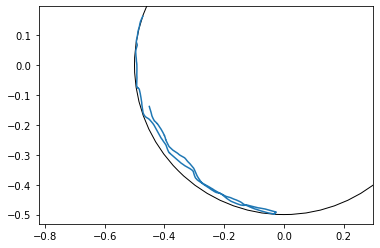

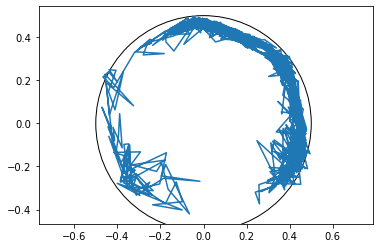

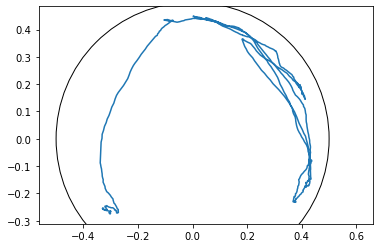

In [6]:
def plot_trajectory(xy):
    plt.plot(*xy.T) #, marker='o', mfc='None', ms=1)
    plt.axis('equal')
    plt.gca().add_patch(plt.Circle((0,0), 0.5, fc='None', ec='k'))
    plt.show()

n   = 51 # Width of the smoothing window.

# True trajectory.
plot_trajectory(pos[n:len(Yp)-n])

# Plot the trajectory generated by the neural network.
plot_trajectory(Yp[n:-n])

# The generated trajectory is way too noisy.
# For now let's just smooth it with a moving average.
Yp2 = np.array([ np.convolve(Yp[:,i], np.ones(n)/n, 'valid') for i in range(Yp.shape[1]) ]).T
plot_trajectory(Yp2)

## Conclusion

Clearly the probabilistic bayesian neural network is able to generate stochastic trajectories. It picked up on the fact that the fish is trapped in a circular tank and prefers to stay near the wall. The noise is much too large though, and the distance to the wall is not very well captured.

Some things to look into:  
- In this particular video the fish doesn't move enough to explore the whole tank, so some regions of the tank have no training data. It may be necessary to combine multiple videos to get a better training data set.
- Try other ways to parametrize the intput and output data. Polar coordinates would better exploit the symmetry of the system. So would using the polar basis components of the velocity rather than the previous position.
- Tweak batch size and hidden layers.
- Try an LSTM neural network.